# Mapping Richmond MSA Economic Indicators and Companies

The United States Census Bureau API was accessed to obtain and map economic and demographic data by Zip Code for Richmond and surrounding counties that represent the Richmond MSA.
Counties that we focused on, in addition to the City of Richmond are:
*	Amelia County
*	Caroline County
*	Charles City County
*	Chesterfield County
*	Dinwiddie County
*	Goochland County
*	Hanover County
*	Henrico County
*	King William County
*	New Kent County
*	Powhatan County
*	Prince George County
*	Sussex County

The metrics that we focused on are:
*	Poverty Rate
*	Unemployment Rate
*	Per Capital Income
*	Median Home Values

---
We started with 92 zipcodes for the Richmond MSA, but after analyzing the data we realized there are missing values or insufficient information. After data clean-up we ended up with 86 zipcodes. We chose to focus on zipcodes as it our opinion it usually presents the neighborhood boundaries where people tend to live, shop, and sometimes work. 
Research Questions

Some of the research questions that we attempted to answer using the information above are:
*	Is there a correlation between the aggregation/location of businesses and poverty rate?
*	Is there a correlation between the aggregation/location of businesses and unemployment rate?
*	Is there a correlation between the aggregation/location of businesses and per capita income?
*	Is there a correlation between the aggregation/location of businesses and median home values?


In [1]:
# Setting Dependencies
%matplotlib inline
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from census import Census
import gmaps
import shapefile as shp
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon 
import mplleaflet
import seaborn as sns
from scipy.stats import linregress, pearsonr, stats

# Setting Census API Key and Google Maps API Key
from config import census_key_class
from config import gkey
c = Census(census_key_class, year=2013)


## Data Exploration and Clean-up

Below we created a dataframe of that includes the aforementioned economic metrics in every zipcode in the United States.

-----
Originally we also wanted to obtain values for the number of people who commute using public transit, and the solo auto commute time (minutes), as well as public transport commute time (minutes) to see if there was a relationship between economic indicators of the neighborhood and how long it takes to commute to a place of work. However due to the lack of available data we decided to remove these values from our final analysis.



In [2]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E","B17001_002E","B25077_001E","B08301_010E",
                          "B15003_022E","B23025_002E","B23025_005E",
                          "B08136_003E","B08136_007E"), {'for': 'zip code tabulation area:*'})





In [3]:

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B25077_001E": "Median Home Value",
                                      "B08301_010E": "Num People Commute Public Transit",
                                      "B15003_022E": "Persons with Bachelor Degree",
                                      "B23025_002E": "People in Labor Force",
                                      "B23025_005E": "People Unemployed",
                                      "B08136_003E": "Solo Auto Commute Time (minutes)",
                                      "B08136_007E": "Public Transport Commute Time (minutes)",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Add in Unemplyment Rate (People Unemployed / People in Labor Force)
census_pd["Unemployment Rate"] = 100 * \
    census_pd["People Unemployed"].astype(
        int) / census_pd["People in Labor Force"].astype(int)

# Final DataFrame
census_pd = census_pd[["Zipcode", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate",
                       "Median Home Value","Persons with Bachelor Degree",
                       "People in Labor Force","People Unemployed","Unemployment Rate" ]]

# Visualize
print(len(census_pd))
census_pd.head()

In [4]:
# Save as a csv
# Note to avoid any issues later, use encoding="utf-8"
census_pd.to_csv("census_data.csv", encoding="utf-8", index=False)

We made sure to save the data in a csv file after an API call. Below we read in the data from the saved csv and we read a file of zipcodes that included only the 92 Richmond MSA Zipcodes.

----
The Richmond MSA Zipcodes data was obtained here: https://www.bestplaces.net/find/zip.aspx?msa=40060&st=VA!


In [5]:
census_pd1= pd.read_csv("./Resources/census_data.csv")
#Read Richmond MSA Zipcodes Excel (92 zipcodes)
zipcodes_df=pd.read_excel("./Resources/zipcodes.xlsx")
#print(zipcodes_df.count())


Next we merged the Richmond MSA zipcodes file and the census data file on zipcode to produce a dataframe that includes census data for Richmond MSA zipcodes only. This dataframe had 92 zipcodes. 

In [6]:
#merge census df and zipcode df on zipcode to get data for Richmond MSA (92 zipcodes)
richmond_msa_census = pd.merge(zipcodes_df,census_pd1,how="left", on=['Zipcode','Zipcode'])

# Display the data table for preview
print(richmond_msa_census.shape)


(92, 13)


In [7]:
richmond_msa_census.head()

,Zipcode,Neighborhood,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Median Home Value,Persons with Bachelor Degree,People in Labor Force,People Unemployed,Unemployment Rate
0,22427,Bowling Green,3702.0,31.5,42232.0,20651.0,447.0,12.074554,196800.0,246.0,2039.0,253.0,12.408043
1,22514,Milford,2451.0,44.6,49271.0,23579.0,239.0,9.751122,147800.0,95.0,1220.0,119.0,9.754098
2,22535,Port Royal,362.0,52.3,51100.0,38654.0,54.0,14.917127,239600.0,41.0,272.0,11.0,4.044118
3,22538,Rappahannock Academy,255.0,42.8,103021.0,33144.0,0.0,0.000000,156300.0,4.0,102.0,0.0,0.000000
4,22546,Ruther Glen,15952.0,36.9,61637.0,26850.0,1976.0,12.387161,186900.0,1312.0,8723.0,1166.0,13.366961


After exploring the dataset and trying to display it on a map we realized that some cells with filled with "-666666666" value. After doing some research we learnt that this entry in the estimate column indicates that either no sample observations or too few sample observations were available to compute an estimate, or a ratio of medians cannot be calculated because one or both of the median estimates falls in the lowest interval or upper interval of an open-ended distribution.

---
We dropped any rows with the value of "-666666666" and now have "clean" data for 86 zipcodes.


----
For more information visit: https://www.census.gov/data/developers/data-sets/acs-5year/data-notes.html



In [8]:
#remove zipcodes with no data identified by -666666666 value 

for cols in richmond_msa_census.columns.tolist()[1:]:
    richmond_msa_census = richmond_msa_census.loc[richmond_msa_census[cols] != -666666666]

print(richmond_msa_census.shape)   

richmond_msa_census=richmond_msa_census.round(2)

richmond_msa_census.describe().round(2)

#richmond_msa_census.head()

(86, 13)


,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Median Home Value,Persons with Bachelor Degree,People in Labor Force,People Unemployed,Unemployment Rate
count,86.00,86.00,86.00,86.00,86.0,86.00,86.00,86.00,86.00,86.00,86.00,86.00
mean,23287.80,14065.63,41.26,64832.17,30846.3,1655.10,10.29,221924.42,1962.07,7474.43,633.57,7.82
std,383.72,13928.43,6.34,23224.00,9985.3,2619.96,8.24,76892.64,2288.41,7438.54,749.67,4.25
min,22427.00,89.00,25.30,19231.00,15740.0,0.00,0.00,82300.00,4.00,26.00,0.00,0.00
25%,23083.75,2510.50,37.80,49075.25,24374.5,228.00,4.70,168975.00,188.00,1313.00,77.75,4.90
50%,23205.50,6265.00,40.80,61787.50,27604.5,570.50,8.28,210850.00,837.00,3528.50,263.00,7.38
75%,23804.50,25877.25,44.08,76434.75,35409.0,1937.25,14.02,260025.00,3516.25,13178.75,942.00,9.92
max,23897.00,50595.00,65.20,165234.00,67963.0,12983.00,39.13,534700.00,8929.00,27307.00,2953.00,20.59


In [9]:
# Save as a csv
richmond_msa_census.to_csv("census_data_richmond_msa.csv", encoding="utf-8", index=False)

We then obtained the coordinates for the 86 zipcodes in the Richmond MSA. We used this helpful link (http://download.geonames.org/export/zip/ ) to get the coordinates for all zipcodes in the US and then merged dataframes to get the final richmond_msa_data dataframe that had all the MSA census data including the coordinates of the zipcodes. 

In [10]:
#get coordinates for all US Zipcodes from here:http://download.geonames.org/export/zip/ and save it to the Resources folder
#read in the file with coordinates for all US Zipcodes 
us_zipcode_coords_df=pd.read_csv("Resources/zipcode_coords/US.txt", sep='\t', header=None)
# , usecols=[1,9,10] names=["Zipcode", "Lat", "Long"] # this only reads columns we need and names them

us_zipcode_coords_df_renamed=us_zipcode_coords_df.rename(columns={1:"Zipcode", 9:"Lat", 10:"Lng" })

#us_zipcode_coords_df_renamed.head()

us_zipcode_coords_df_clean=us_zipcode_coords_df_renamed.drop([0,2,3,4,5,6,7,8,11], axis=1)
us_zipcode_coords_df_clean.head()

,Zipcode,Lat,Lng
0,99553,54.1430,-165.7854
1,99571,55.1858,-162.7211
2,99583,54.8542,-163.4113
3,99612,55.0628,-162.3056
4,99661,55.3192,-160.4914


In [11]:
#merge richmond_msa_census and us_zipcode_coords_df on Zipcode to get Richmond MSA Census by Zipcode with coordinates 

richmond_msa_data = pd.merge(richmond_msa_census,us_zipcode_coords_df_clean,how="left", on=['Zipcode'])

# Display the data table for preview
print(richmond_msa_data.shape)
richmond_msa_data.head()

(86, 15)


,Zipcode,Neighborhood,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Median Home Value,Persons with Bachelor Degree,People in Labor Force,People Unemployed,Unemployment Rate,Lat,Lng
0,22427,Bowling Green,3702.0,31.5,42232.0,20651.0,447.0,12.07,196800.0,246.0,2039.0,253.0,12.41,38.0137,-77.1802
1,22514,Milford,2451.0,44.6,49271.0,23579.0,239.0,9.75,147800.0,95.0,1220.0,119.0,9.75,38.0058,-77.3185
2,22535,Port Royal,362.0,52.3,51100.0,38654.0,54.0,14.92,239600.0,41.0,272.0,11.0,4.04,38.1621,-77.1837
3,22538,Rappahannock Academy,255.0,42.8,103021.0,33144.0,0.0,0.00,156300.0,4.0,102.0,0.0,0.00,38.2079,-77.2502
4,22546,Ruther Glen,15952.0,36.9,61637.0,26850.0,1976.0,12.39,186900.0,1312.0,8723.0,1166.0,13.37,37.9451,-77.4714


In [12]:
# Save as a csv
# Note to avoid any issues later, use encoding="utf-8"
richmond_msa_data.to_csv("richmond_msa_data_final.csv", encoding="utf-8", index=False)

### Geodata

While we use google maps API to create maps to visualize some relationships in the research questions, we mainly  decided to use Geopandas to create choropleth maps. 

---
A choropleth map uses differences in shading, coloring, or the placing of symbols within predefined areas to indicate the average values of a property or quantity in those areas. We used these maps to show the distribution of Population, Poverty Rate, Unemployment rate, Per Capita income, Median Home Values, and business locations per zipcode in the Richmond MSA.

---

In order to use a choropleth map we had to download shapefiles for all use zipcodes from Census (https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-data.2014.html). Then we used QGIS to filter down the shapefile feature to only include the Richmond MSA zipcodes. 


In [13]:
# set the filepath and load in a shapefile
map_df = gpd.read_file("Resources/msa_shapefiles/richmond_msa_zip_shapes_v2.shp")

# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,23086,23086,B5,G6350,S,214079105,8271160,+37.6685728,-077.0544136,"POLYGON ((-77.14329599999999 37.70315, -77.143..."
1,23089,23089,B5,G6350,S,156973737,16549281,+37.4557955,-076.9035007,"POLYGON ((-76.935571 37.45016, -76.935569 37.4..."
2,23102,23102,B5,G6350,S,76852096,2649367,+37.7081193,-077.8286536,"POLYGON ((-77.85095 37.744712, -77.85100199999..."
3,23103,23103,B5,G6350,S,96916288,3573755,+37.6480344,-077.7236401,"POLYGON ((-77.776394 37.66745299999999, -77.77..."
4,23106,23106,B5,G6350,S,69705538,987148,+37.7161066,-077.2015109,"POLYGON ((-77.169022 37.708327, -77.1689959999..."


In [14]:
map_df_renamed= map_df.rename(columns={"GEOID10":"Zipcode"})
map_df_renamed.dtypes


ZCTA5CE10     object
Zipcode       object
CLASSFP10     object
MTFCC10       object
FUNCSTAT10    object
ALAND10        int64
AWATER10       int64
INTPTLAT10    object
INTPTLON10    object
geometry      object
dtype: object

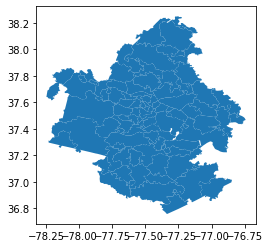

In [15]:
#display the shapefile to make sure the output is correct
map_df_renamed.plot()


We merged the Richmond MSA Census data with the Richmond shapefiles data to create one dataframe for plotting.

In [16]:
# join the geodataframe with the cleaned up csv dataframe
richmond_msa_data2=richmond_msa_data.astype({'Zipcode': 'str'})

merged_map_df = map_df_renamed.merge(richmond_msa_data2, on="Zipcode")
#merged_map_df.head()
#merged_map_df.count()
merged_map_df.describe().round(2)

,ALAND10,AWATER10,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Median Home Value,Persons with Bachelor Degree,People in Labor Force,People Unemployed,Unemployment Rate,Lat,Lng
count,8.600000e+01,86.00,86.00,86.00,86.00,86.0,86.00,86.00,86.00,86.00,86.00,86.00,86.00,86.00,86.00
mean,1.377458e+08,3586631.40,14065.63,41.26,64832.17,30846.3,1655.10,10.29,221924.42,1962.07,7474.43,633.57,7.82,37.50,-77.47
std,1.328809e+08,7159248.94,13928.43,6.34,23224.00,9985.3,2619.96,8.24,76892.64,2288.41,7438.54,749.67,4.25,0.29,0.27
min,9.170100e+05,0.00,89.00,25.30,19231.00,15740.0,0.00,0.00,82300.00,4.00,26.00,0.00,0.00,36.84,-78.18
25%,3.859322e+07,651899.25,2510.50,37.80,49075.25,24374.5,228.00,4.70,168975.00,188.00,1313.00,77.75,4.90,37.34,-77.64
50%,9.554470e+07,1535275.50,6265.00,40.80,61787.50,27604.5,570.50,8.28,210850.00,837.00,3528.50,263.00,7.38,37.51,-77.45
75%,1.930044e+08,3290803.75,25877.25,44.08,76434.75,35409.0,1937.25,14.02,260025.00,3516.25,13178.75,942.00,9.92,37.70,-77.32
max,6.727370e+08,55184897.00,50595.00,65.20,165234.00,67963.0,12983.00,39.13,534700.00,8929.00,27307.00,2953.00,20.59,38.21,-76.82


In [17]:
merged_map_df.to_csv("merged_map_data.csv", encoding="utf-8", index=False)


Separately, we decided to add some references to the maps and crated a dataframe that includes added areas of interest or neighborhoods in the Richmond MSA. This small dataframe was created by googling the latitude and longitude for each location. It is also possible to get this using google maps API.

In [18]:
areas_interest=pd.read_excel("./Resources/areas_of_interest.xlsx")
areas_interest

,area,lat,long
0,Richmond,37.524776,-77.563301
1,Petersburg,37.204846,-77.427798
2,Hopewell,37.287690,-77.330094
3,Glen Allen,37.664692,-77.522917
4,Goochland,37.696081,-77.916636
5,Manquin,37.707341,-77.172409
6,Mechanicsville,37.628407,-77.392392
7,Chesterfield,37.390003,-77.701379


##  Making Maps, Observations and Conclusions

Using Geopandas we first produced maps of population, poverty rate, unemployment rate, per capita income and median home value for each zipcode in the Richmond MSA. We found a helpful tutorial on how to make maps using geopandas here (https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d)

---
In some maps we plotted multiple layers using geopands for the choropleth map and also shapely.geometry such as Point, Polygon to add in areas of interest and employers.


In [19]:
print(merged_map_df["Population"].max())
print(merged_map_df["Population"].sum())

50595.0
1209644.0


### Population Map

Total Richmond MSA population is around 1.2M. Zipcodes with the largest populations tend to cluster in the middle of the MSA. The most populous neighborhoods were in Midlothian and Richmond.

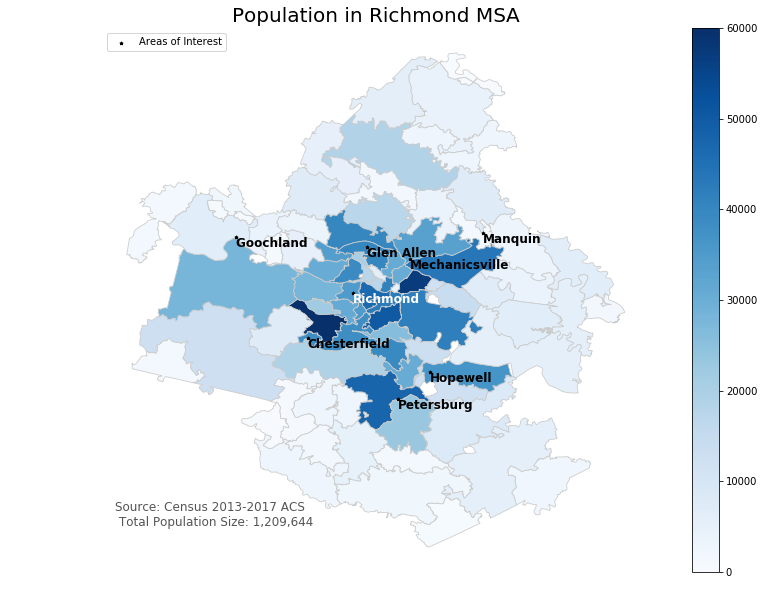

In [20]:
#population map
# set a variable that will call whatever column we want to visualise on the map
variable = "Population"
# set the range for the choropleth
vmin, vmax = 0, 60000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))
# create population map layer 
merged_map_df.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")

#create areas of interest map layer (points)
geometry2= [Point (xy)for xy in zip (areas_interest["long"],areas_interest["lat"])]

geo_df4=gpd.GeoDataFrame(areas_interest, geometry=geometry2)

geo_df4.plot(markersize=10, color= "Blue", marker="*", ax=ax,edgecolor="black", label= "Areas of Interest")

plt.legend(prop={"size":10}, loc="upper left")

for index, row in areas_interest.iterrows():
    area, long, lat = row["area"], row["long"], row["lat"]
    ax.annotate(area, xy=(long,lat),
                horizontalalignment="left", 
                verticalalignment="top", 
                fontsize=12, color=("Black" if area != "Richmond" else "White"),
                fontweight="bold")

    
# remove the axis
ax.axis("off")

# add a title
ax.set_title("Population in Richmond MSA", fontdict={"fontsize": "20", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013-2017 ACS""\n Total Population Size: 1,209,644", xy=(0.15, .15), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

plt.savefig("./maps/Population in Richmond MSA",dpi = 300)

### Poverty Rate Map
The City of Richmond neighborhoods had some of the highest poverty rates. What also interesting the zipcode of Manquin that had the highest poverty rate of approximately 39%. The average poverty rate in the MSA is 10.29% which is a bit lower than the national poverty rate of 11.8%. While there is a clear cluster of poverty around the urban area of the city of Richmond, there are also pockets of poverty in rural areas of the MSA.

---
(source for national poverty rate: https://census.gov/library/stories/2019/09/poverty-rate-for-people-in-female-householder-families-lowest-on-record.html)

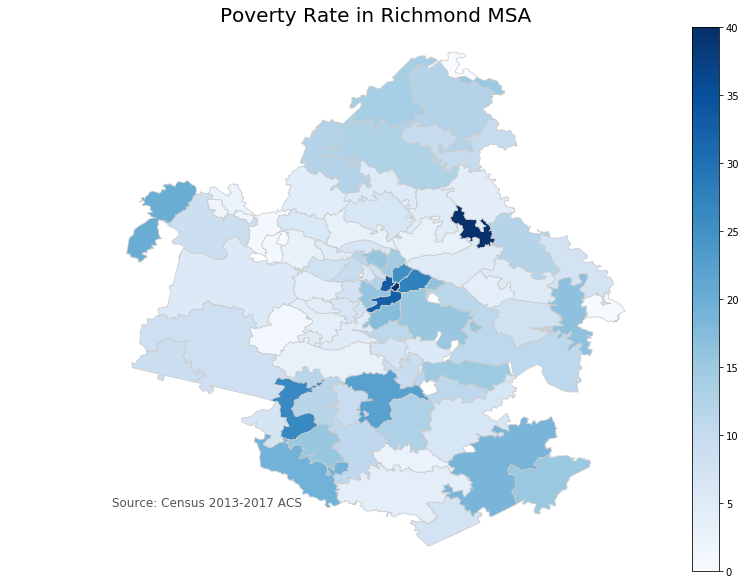

In [21]:
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
# set a variable that will call whatever column we want to visualise on the map
variable = "Poverty Rate"
# set the range for the choropleth
vmin, vmax = 0, 40
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))
# create map
merged_map_df.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")

# remove the axis
ax.axis("off")

# add a title
ax.set_title("Poverty Rate in Richmond MSA", fontdict={"fontsize": "20", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013-2017 ACS", xy=(0.15, .15), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

plt.savefig("./maps/Poverty Rate in Richmond MSA",dpi = 300)
            
            

Displaying the heatmap of poverty rate using google API for comparison purposes. 

In [22]:


# Store 'Lat' and 'Lng' into  locations 
locations = richmond_msa_data[["Lat", "Lng"]]


# Convert Poverty Rate to float and store
# HINT: be sure to handle NaN values
poverty_rate = richmond_msa_data["Poverty Rate"]

# Create a poverty Heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=poverty_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 0.075)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 40
heat_layer.point_radius = 0.075

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

### Unemployment Rate Map

The highest unemployment rate for the MSA was at Ford with about 20%. However, we need keep in mind that while the area of this zipcode is relatively large, its population is relatively small of 743 people and 306 individuals in labor force. The actual number of people who are not employed at the zipcode is only 63. The average unemployment rate at the MSA is 7.8% which is much higher than the national unemployment rate of 3.7%.

---
(source for the national unemployment rate: https://www.bls.gov/news.release/pdf/empsit.pdf)

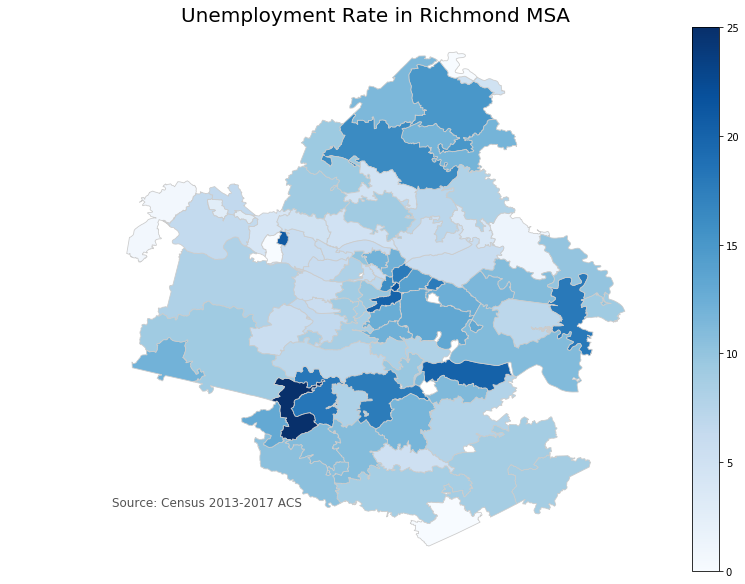

In [23]:
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
# set a variable that will call whatever column we want to visualise on the map
variable = "Unemployment Rate"
# set the range for the choropleth
vmin, vmax = 0, 25
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))
# create map
merged_map_df.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")

# remove the axis
ax.axis("off")

# add a title
ax.set_title("Unemployment Rate in Richmond MSA", fontdict={"fontsize": "20", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013-2017 ACS", xy=(0.15, .15), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

plt.savefig("./maps/Unemployment Rate in Richmond MSA",dpi = 300)
            

### Per Capita Income Map

Neighborhoods with the largest per capita income values clustered in the northwest of the MSA. The average per capita  income was $30,846.

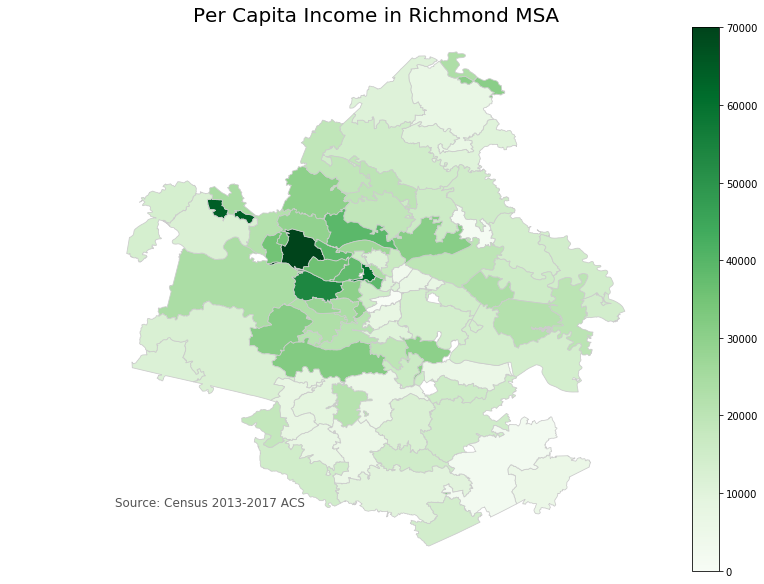

In [24]:
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
# set a variable that will call whatever column we want to visualise on the map
per_capita_income = merged_map_df["Per Capita Income"]

variable = per_capita_income
# set the range for the choropleth
vmin, vmax = 0, 70000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))
# create map
merged_map_df.plot(column=variable, cmap="Greens", linewidth=0.8, ax=ax, edgecolor="0.8")

# remove the axis
ax.axis("off")

# add a title
ax.set_title("Per Capita Income in Richmond MSA", fontdict={"fontsize": "20", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013-2017 ACS", xy=(0.15, .15), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

plt.savefig("./maps/Per Capita Income in Richmond MSA",dpi = 300)

### Median Home Value Map

Some of the highest Median home values also clustered towards the northwest of the MSA, almost following the median per capita income distribution.

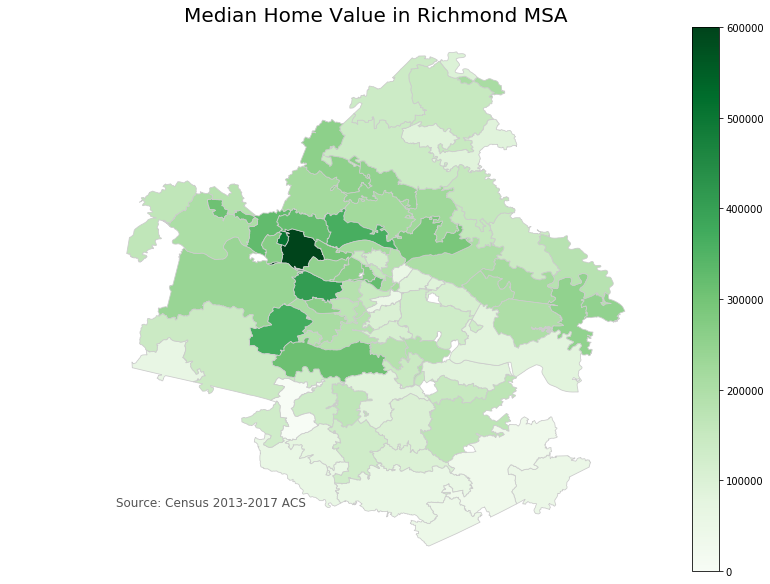

In [25]:

# set a variable that will call whatever column we want to visualise on the map
median_home_value=  merged_map_df["Median Home Value"]

variable = median_home_value
# set the range for the choropleth
vmin, vmax = 0, 600000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))
# create map
merged_map_df.plot(column=variable, cmap="Greens", linewidth=0.8, ax=ax, edgecolor="0.8")

# remove the axis
ax.axis("off")

# add a title
ax.set_title("Median Home Value in Richmond MSA", fontdict={"fontsize": "20", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013-2017 ACS", xy=(0.15, .15), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")


# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

plt.savefig("./maps/Median Home Value in Richmond MSA",dpi = 300)

#### Pearson's Correlation Coefficient Analysis
Since the maps of the economic indicators followed a nice trend on a map, we decided to see if they were correlated using Pearson's Correlation Coefficient Analysis. The correlation coefficient for Income and Home Value was 0.78 for example, indicating a strong positive correlation.

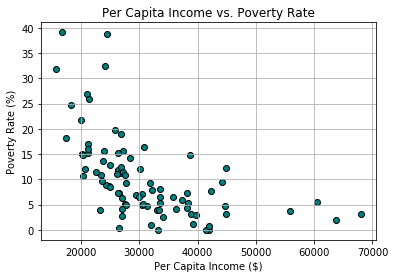

In [26]:
#Per Capital Income vs. Poverty Rate  
plt.scatter(merged_map_df["Per Capita Income"],merged_map_df["Poverty Rate"], marker="o",
            facecolors="teal", edgecolors="black")

# Incorporate the other graph properties
plt.title("Per Capita Income vs. Poverty Rate")
plt.ylabel("Poverty Rate (%)")
plt.xlabel("Per Capita Income ($)")
plt.grid(None)

# Save the figure
#plt.savefig(Per Capita Income vs. Poverty Rate",bbox_inches="tight", dpi = 300)

# Show plot
plt.show()

In [27]:
#Per Capital Income vs. Poverty Rate R Coefficeint 
x=merged_map_df["Per Capita Income"]
y=merged_map_df["Poverty Rate"]
correlation_x_y, p_value = stats.pearsonr(x, y)
correlation_x_y

-0.5574810879110366

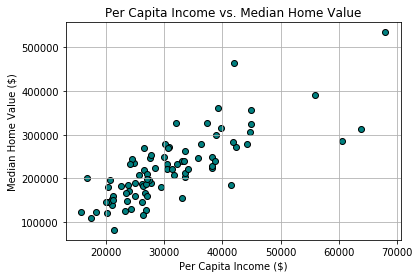

In [28]:
#Per Capita Income vs. Median Home Value
plt.scatter(merged_map_df["Per Capita Income"],merged_map_df["Median Home Value"], marker="o",
            facecolors="teal", edgecolors="black")

# Incorporate the other graph properties
plt.title("Per Capita Income vs. Median Home Value")
plt.ylabel("Median Home Value ($)")
plt.xlabel("Per Capita Income ($)")
plt.grid(None)

# Save the figure
#plt.savefig("Per Capita Income vs. Median Home Value",bbox_inches="tight", dpi = 300)

# Show plot
plt.show()

In [29]:
#Per Capital Income vs. Median Home Value R Coefficeint 
x=merged_map_df["Per Capita Income"]
y=merged_map_df["Median Home Value"]
correlation_x_y, p_value = stats.pearsonr(x, y)
correlation_x_y

0.7902323637484572

### Median Home Values and Companies Maps

The companies data was obtained from the Greater Richmond Partnership. The latitude and the longitude for all companies was obtained using geocoding via google maps API. In the case of the top 10 corporate employers the data for the latitude and longitude values was obtained via google search. We mapped companies with 50 employees or more instead of mapping the entire list, partly because we had to obtain the lat and the long values via google API and would have needed to do that for over 20,000 companies. There are about 1,900 companies with 50+ employees at location in the Richmond MSA. We also believe it is a large enough sample to evaluate against the economic indicators.

##### Is there a correlation between the aggregation/location of businesses and median home value?

Based on the Median Home Values vs Companies Maps it we can see that while in the urban core of the MSA values are average or below average, the highest median home values are observed in sub-urban neighborhoods that are within a reasonable commute distance from such companies. This is to be expected as the urban core usually consists of office buildings and multi-family apartments.


In [30]:
#Importing data for the top 10 companies including lat and long values 

employers=pd.read_csv("./Resources/largest_employers_top_ten.csv")

clean_employers = employers[["Rank", "Company Name", "Address", "Zipcode", "Line of Business",
                                      "Employees", "Lat", "Long"]]
clean_employers

,Rank,Company Name,Address,Zipcode,Line of Business,Employees,Lat,Long
0,1,Capital One Financial Corp.,Westcreek,23238,Financial services,"13,000",37.622219,-77.635360
1,2,Virginia Cmnwlth. Univ. Health Syst,"1601 Willow Lawn Dr, Richmond, VA 23230",23230,Health Care,"9,313",37.581793,-77.500616
2,3,HCA Virginia Health System,"7101 Jahnke Rd, Richmond, VA 23225",23225,Health Care,"7,628",37.514285,-77.526281
3,4,Bon Secours Richmond,"Forest Ave, Richmond, VA 23229",23229,Health Care,"7,136",37.600388,-77.536300
4,5,Dominion Virginia Power,"400 Scott Rd, Richmond, VA 23227",23227,Energy,"5,433",37.649772,-77.438644
5,6,SunTrust Banks Inc.,"919 E Main St, Richmond, VA 23219",23219,Financial services,"3,810",37.537607,-77.438223
6,7,Altria Group Inc.,"6601 W Broad St, Richmond, VA 23230",23230,Manufacturing,"3,800",37.537035,-77.543983
7,7,Amazon.com,"1901 Meadowville Technology Pkwy, Chester, VA ...",23836,Retailer,"3,800",37.352022,-77.329247
8,9,Wells Fargo,"1021 E Cary St Ste 100, Richmond, VA 23219",23219,Financial services,"2,902",37.536119,-77.437935
9,10,Anthem Blue Cross and Blue Shield,"2015 Staples Mill Rd, Richmond, VA 23230",23230,Insurance,"2,655",37.536239,-77.505787


In [51]:
clean_employers_lat_long=clean_employers[["Lat","Long"]]


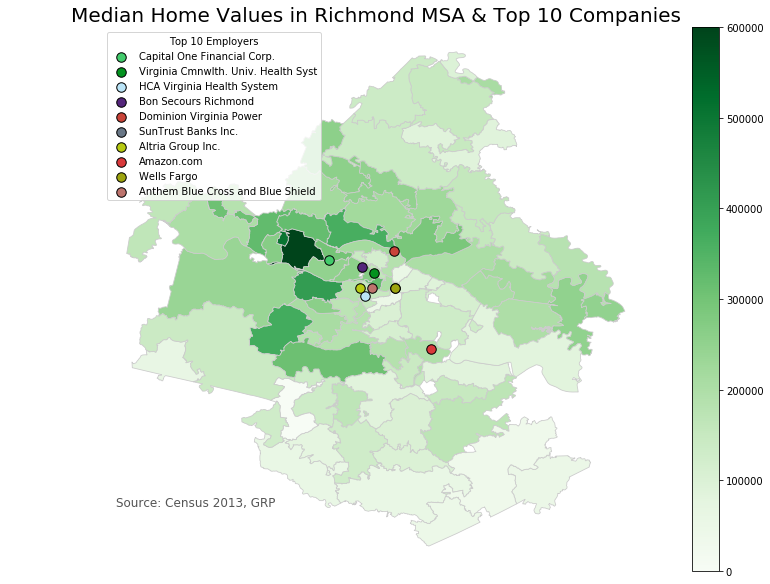

In [36]:
# set a variable that will call whatever column we want to visualise on the map
median_home_value= merged_map_df["Median Home Value"]


variable = median_home_value
# set the range for the choropleth
vmin, vmax = 0, 600000

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))

# create map

merged_map_df.plot(column=variable, cmap="Greens", linewidth=0.8, ax=ax, edgecolor="0.8")

#plot companies 
geometry= [Point (xy)for xy in zip (clean_employers["Long"],clean_employers["Lat"])]

geo_df=gpd.GeoDataFrame(clean_employers, geometry=geometry)

for i, txt in enumerate(clean_employers["Company Name"]):
    geo_df[geo_df["Company Name"]==txt].plot(markersize=90, color=np.random.rand(3,),
                                             marker="o", ax=ax,edgecolor="black", label=txt)

plt.legend(prop={"size":10}, loc="upper left",title="Top 10 Employers")

ax.axis("off")

# add a title
ax.set_title("Median Home Values in Richmond MSA & Top 10 Companies", fontdict={"fontsize": "20", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013, GRP", xy=(0.15, .15), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)


plt.savefig("./maps/Median Home Values and Top 10 Companies",dpi = 300)



For Comparison Purposes Displayed the Top 10 Companies locations using google maps API

In [38]:
compnay_locations = clean_employers["Company Name"].tolist() 
marker_locations = clean_employers[['Lat', 'Long']]

# Create a marker_layer using the company name list to fill the info box
fig = gmaps.figure()
markers = gmaps.marker_layer(marker_locations,
    info_box_content=[f"Business Name: {name}" for name in compnay_locations])
fig.add_layer(markers)
fig


Figure(layout=FigureLayout(height='420px'))

Importing data provided by GRP and selecting only companies with 50 or more employees. The number of companies in that data set is 1905.

In [39]:
#Importing data provided by GRP and selecting only companies with 50 or more employees
all_employers=pd.read_csv("./Resources/Master List-Employee Above 5-MSA Regions.csv")

employees_over25=all_employers[all_employers["Location Employee Size"]>=50]
#employees_over25.shape


all_employers_clean = employees_over25[["Business Name", "Physical Address", "Physical City", 
                                        "Physical State", "Physical ZIP", "Location Employee Size", "2017 Employees"]].dropna()
all_employers_clean.head()

# total number of compnaies analzyed here is 4594
    
all_employers_clean.shape




(1905, 7)

Adding a progress bar to help visualize data import progress

In [ ]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    

Getting lat and long values for the 1905 companies from Google API from the provided address. 

In [ ]:
number_of_elements = len(all_employers_clean.index)


all_employers_clean['Lat'] = np.nan
all_employers_clean['Lng'] = np.nan

base_url = "https://maps.googleapis.com/maps/api/geocode/json"

for index, row in all_employers_clean[["Physical Address", "Physical City", 
                                        "Physical State", "Physical ZIP"]].iterrows():
    address, city, state, zipcode = row["Physical Address"], row["Physical City"], row["Physical State"], row["Physical ZIP"]
    
    my_address = (f"{address}, {city}, {state},{str(zipcode)}")
    
    params = {
        "address": my_address,
        "key": gkey
    }

    my_geo = requests.get(base_url, params).json()
   
    try:
    
        all_employers_clean.loc[index, 'Lat'] = my_geo["results"][0]["geometry"]["location"]["lat"]
        all_employers_clean.loc[index, 'Lng'] = my_geo["results"][0]["geometry"]["location"]["lng"]

    except (KeyError, IndexError):
        print(f"Missing field/result for: {my_address} ... skipping.")
    #print(f"{my_address}: {lat}, {lng}")
    update_progress(index / number_of_elements)
update_progress(1)
    
print("Done!!!")

In [ ]:
all_employers_clean.to_csv("Companies Equal or over 50 Employees.csv", encoding="utf-8", index=False)

Reading in the dataframe for companies with 50+ employees 

In [44]:
employers50andover=pd.read_csv("./Resources/Companies Equal or over 50 Employees.csv").dropna()
employers50andover.describe()

,Physical ZIP,Location Employee Size,2017 Employees,Lat,Lng
count,1903.000000,1903.000000,1903.000000,1903.000000,1903.000000
mean,23250.782449,140.503416,484.496584,37.545114,-77.491595
std,220.274606,292.885022,7618.953144,0.121097,0.092438
min,22546.000000,50.000000,50.000000,37.158510,-77.808335
25%,23116.000000,60.000000,60.000000,37.498554,-77.566033
50%,23226.000000,78.000000,78.000000,37.548028,-77.479989
75%,23235.000000,130.000000,130.000000,37.623124,-77.432689
max,23838.000000,8202.000000,310000.000000,38.030855,-76.958269


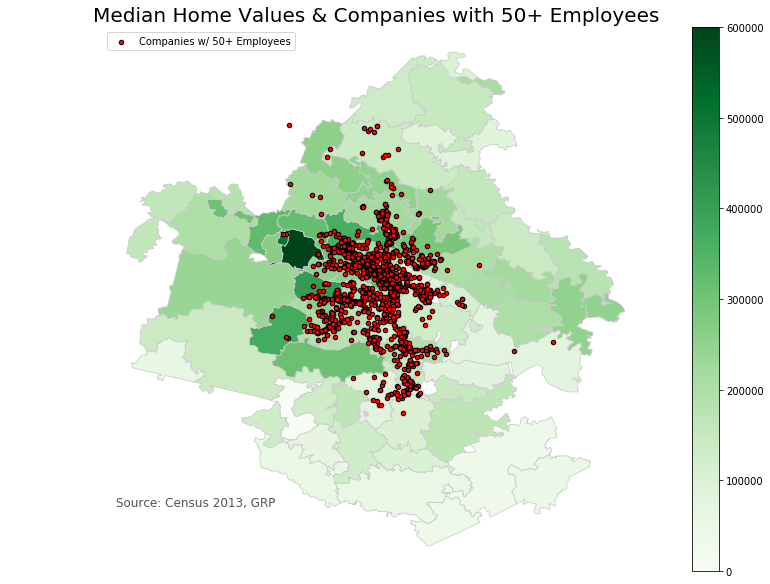

In [45]:
# set a variable that will call whatever column we want to visualise on the map
median_home_value= merged_map_df["Median Home Value"]

variable = median_home_value
# set the range for the choropleth
vmin, vmax = 0, 600000

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))

# create map

merged_map_df.plot(column=variable, cmap="Greens", linewidth=0.8, ax=ax, edgecolor="0.8")

#plot companies 

geometry= [Point (xy)for xy in zip (employers50andover["Lng"],employers50andover["Lat"])]

geo_df1=gpd.GeoDataFrame(employers50andover, geometry=geometry)

geo_df1.plot(markersize=20, color= "red", marker="o", ax=ax,edgecolor="black", label="Companies w/ 50+ Employees")

plt.legend(prop={"size":10}, loc="upper left")


ax.axis("off")

# add a title
ax.set_title("Median Home Values & Companies with 50+ Employees",
             fontdict={"fontsize": "20", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013, GRP", xy=(0.15, .15), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")




# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)


plt.savefig("./maps/Median Home Values-Companies with 50+ Employees",dpi = 300)


In [46]:
# For comparison purposes also displayed the 50+ employess companies on google maps!
employers50andover_locations = employers50andover["Business Name"].tolist() 
marker_locations = employers50andover[['Lat', 'Lng']]


# Create a marker_layer using the poverty list to fill the info box
fig = gmaps.figure()
markers = gmaps.marker_layer(marker_locations,
     info_box_content=[f"Business Name: {name}" for name in employers50andover_locations])
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(height='420px'))

#### Is there a correlation between the aggregation/location of businesses and poverty rate?
There does not seem to be a clear correlation between poverty and business locations. Poverty was the highest at the center of the MSA where the many of the companies cluster. Just like with the home values, it seems that poverty is lowest in sub-urban neighborhoods that are within a reasonable commute distance from the companies.

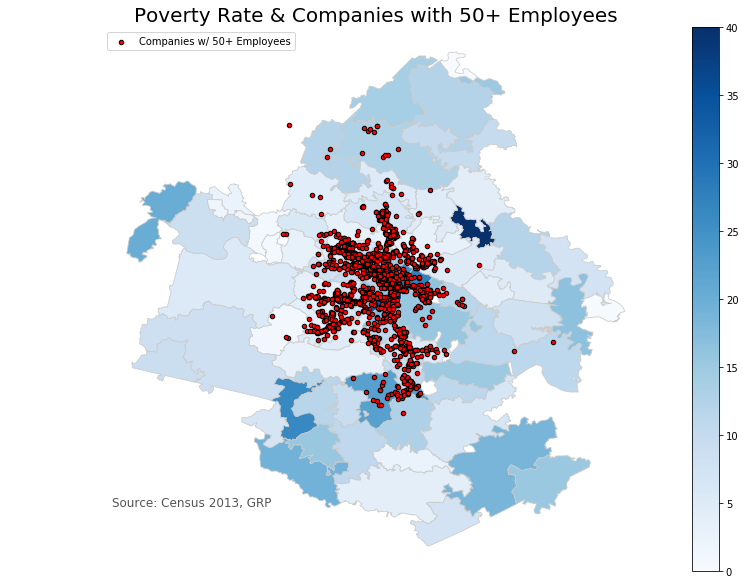

In [47]:
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
# set a variable that will call whatever column we want to visualise on the map
variable = "Poverty Rate"
# set the range for the choropleth
vmin, vmax = 0, 40
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))
# create map
merged_map_df.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")

#Map companies

geometry= [Point (xy)for xy in zip (employers50andover["Lng"],employers50andover["Lat"])]

geo_df3=gpd.GeoDataFrame(employers50andover, geometry=geometry)

geo_df3.plot(markersize=20, color= "red", marker="o", ax=ax,edgecolor="black",label="Companies w/ 50+ Employees")

plt.legend(prop={"size":10}, loc="upper left")


# remove the axis
ax.axis("off")

# add a title
ax.set_title("Poverty Rate & Companies with 50+ Employees", fontdict={"fontsize": "20", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013, GRP", xy=(0.15, .15), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

plt.savefig("./maps/Poverty Rate & Companies with 50+ Employees",dpi = 300)
            

#### Is there a correlation between the aggregation/location of businesses and unemployment rate?
Unemployment rate seem to closely follow the poverty rate distribution. There does not seem to be a clear correlation between unemployment rate and business locations. Unemployment was the highest at the center of the MSA where the many of the companies cluster. Just like with the home values, it seems that unemployment is lowest in sub-urban neighborhoods that are within a reasonable commute distance from the companies. It is interesting that while many jobs are located at the MSA core, it still has one of the highest unemployment rates.

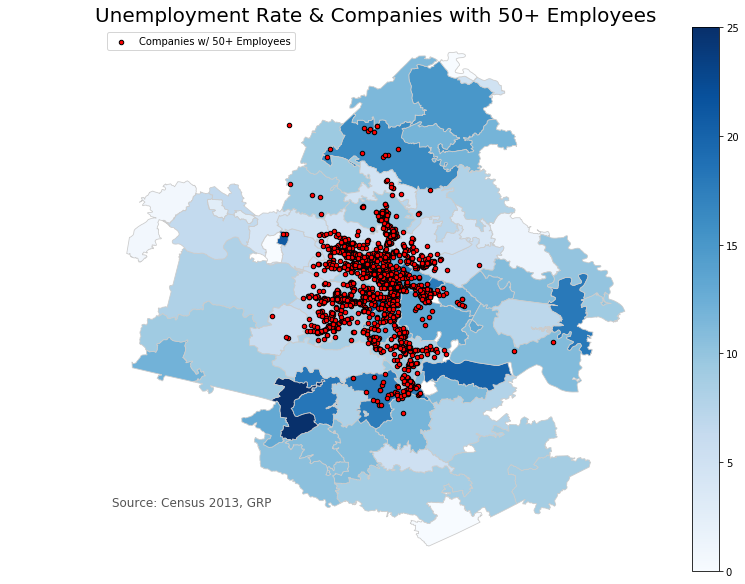

In [48]:
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
# set a variable that will call whatever column we want to visualise on the map
variable = "Unemployment Rate"
# set the range for the choropleth
vmin, vmax = 0, 25
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))
# create map
merged_map_df.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")

geometry= [Point (xy)for xy in zip (employers50andover["Lng"],employers50andover["Lat"])]

geo_df3=gpd.GeoDataFrame(employers50andover, geometry=geometry)

geo_df3.plot(markersize=20, color= "red", marker="o", ax=ax,edgecolor="black",label="Companies w/ 50+ Employees")

plt.legend(prop={"size":10}, loc="upper left")

# remove the axis
ax.axis("off")

# add a title
ax.set_title("Unemployment Rate & Companies with 50+ Employees", fontdict={"fontsize": "20", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013, GRP", xy=(0.15, .15), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

plt.savefig("./maps/Unemployment Rate & Companies with 50+ Employees",dpi = 300)

#### Is there a correlation between the aggregation/location of businesses and per capita income?
The income was also inconclusive. While it is clear that sub-urban neighborhoods that are in commuting proximity to business aggregations had the highest incomes, there are urban areas within the business district that have some of the lowest incomes.

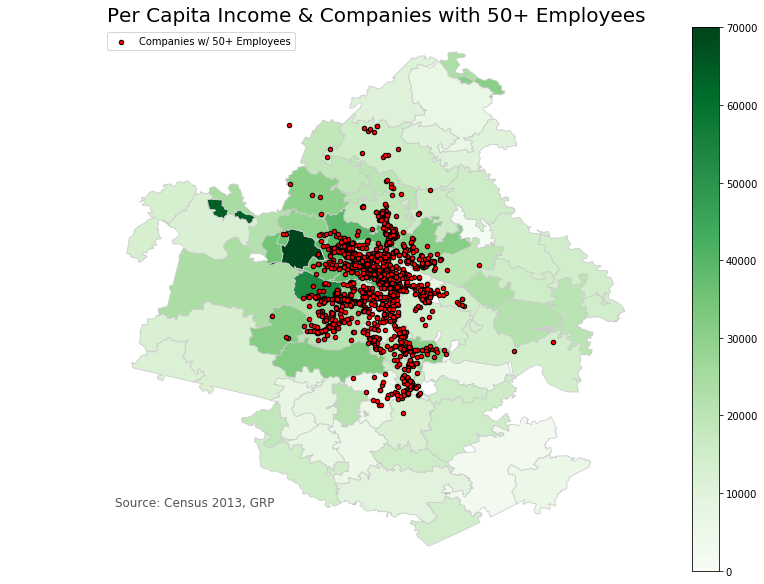

In [49]:
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
# set a variable that will call whatever column we want to visualise on the map
per_capita_income = merged_map_df["Per Capita Income"]

variable = per_capita_income
# set the range for the choropleth
vmin, vmax = 0, 70000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))
# create map
merged_map_df.plot(column=variable, cmap="Greens", linewidth=0.8, ax=ax, edgecolor="0.8")

geometry= [Point (xy)for xy in zip (employers50andover["Lng"],employers50andover["Lat"])]

geo_df2=gpd.GeoDataFrame(employers50andover, geometry=geometry)

geo_df2.plot(markersize=20, color= "red", marker="o", ax=ax,edgecolor="black",label="Companies w/ 50+ Employees")

plt.legend(prop={"size":10}, loc="upper left")


# remove the axis
ax.axis("off")

# add a title
ax.set_title("Per Capita Income & Companies with 50+ Employees", fontdict={"fontsize": "20", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013, GRP", xy=(0.15, .15), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)


plt.savefig("./maps/Per Capita Income & Companies with 50+ Employees",dpi = 300)

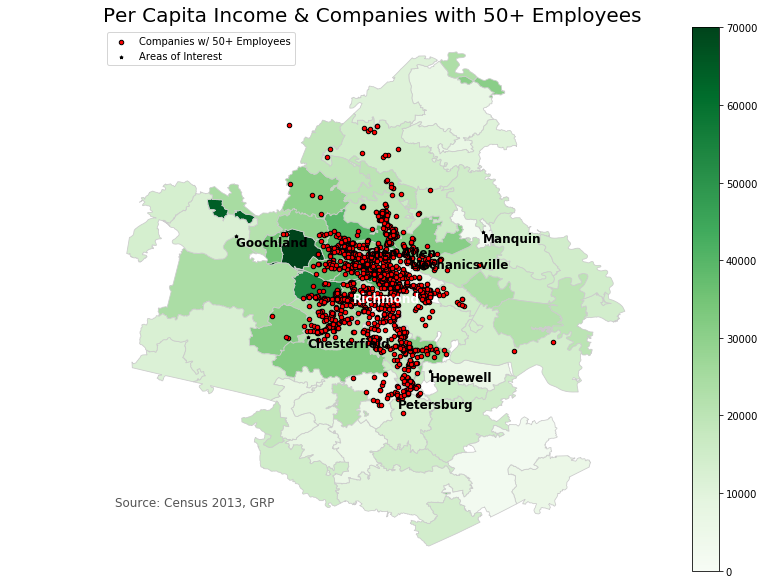

In [50]:
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
# set a variable that will call whatever column we want to visualise on the map
per_capita_income = merged_map_df["Per Capita Income"]

variable = per_capita_income
# set the range for the choropleth
vmin, vmax = 0, 70000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))
# create map
merged_map_df.plot(column=variable, cmap="Greens", linewidth=0.8, ax=ax, edgecolor="0.8")

geometry= [Point (xy)for xy in zip (employers50andover["Lng"],employers50andover["Lat"])]

geo_df3=gpd.GeoDataFrame(employers50andover, geometry=geometry)

geo_df3.plot(markersize=20, color= "red", marker="o", ax=ax,edgecolor="black",label="Companies w/ 50+ Employees")

plt.legend(prop={"size":10}, loc="upper left")


geometry2= [Point (xy)for xy in zip (areas_interest["long"],areas_interest["lat"])]

geo_df4=gpd.GeoDataFrame(areas_interest, geometry=geometry2)

geo_df4.plot(markersize=10, color= "Blue", marker="*", ax=ax,edgecolor="black", label= "Areas of Interest")

plt.legend(prop={"size":10}, loc="upper left")

for index, row in areas_interest.iterrows():
    area, long, lat = row["area"], row["long"], row["lat"]
    ax.annotate(area, xy=(long,lat),
                horizontalalignment="left", 
                verticalalignment="top", 
                fontsize=12, color=("Black" if area != "Richmond" else "White"),
                fontweight="bold")




# remove the axis
ax.axis("off")

# add a title
ax.set_title("Per Capita Income & Companies with 50+ Employees ", fontdict={"fontsize": "20", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013, GRP", xy=(0.15, .15), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")



# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)




plt.savefig("./maps/test",dpi = 300)

### Data Limitations and Further Research 

The maps visualize the economic indicators well, however they do not perfectly align with the location of employers. We think it is an interesting conclusion that overall there is no strong relationship between the aggregation of employers and economic indicators in the Richmond MSA with the urban areas having some of the highest poverty rates and unemployment rates. 

As mentioned this is only a subset of the 20,000+ companies in the MSA. It would be interesting to examine how are companies with less than 50 employees at location are distributed across the MSA, are these mostly service businesses that tend to be near residential areas and whether there might be a larger impact on the economic indicators?
 
Additionally, it will be interesting to see explore these relationship different using statistical analysis on business density (business count per zipcode) and the value of the economic indicator of that zipcode.

There is a plethora of other factors that affects where companies tend to be including tax incentives, availability of labor, transit lines etc. It will be interesting to see how an appearance of company aggregation certain locations affects areas over time. 
